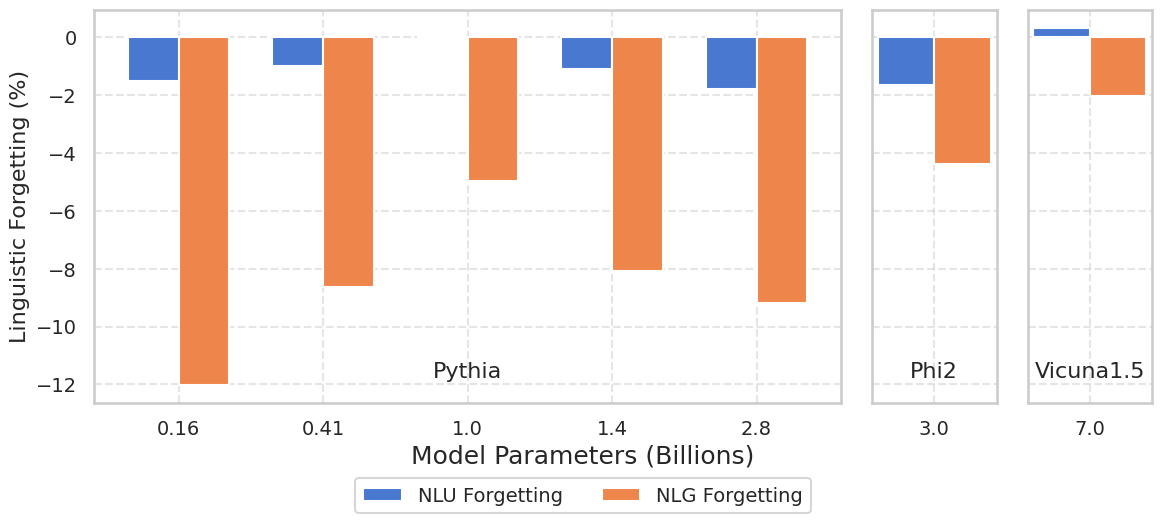

In [81]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
sns.set_palette("muted")
sns.set_context("talk")
plt.rcParams.update({
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.figsize': [16, 6],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

# Load the JSON data from the file
with open('results_nlp.json', 'r') as f:
    results = json.load(f)

# Define the filtering criteria and datasets
nlu_datasets = ["wsc273", "winogrande", "arc_easy", "arc_challenge"]
nlg_datasets = ["lambada_standard"]
all_datasets = nlu_datasets + nlg_datasets

# Define explicit mappings for LLaVA Originals and Base LLMs for each model type
model_mappings = {
    'Pythia': {
        'llava_original': {
            0.16: "stage-final-llava-v15-pythia+160m",
            0.41: "stage-final-llava-v15-pythia+410m",
            1.0: "stage-final-llava-v15-pythia+1b",
            1.4: "stage-final-llava-v15-pythia+1p4b",
            2.8: "stage-final-llava-v15-pythia+2p8b"
        },
        'base_llm': {
            0.16: "reproduction-align-pythia+160m",
            0.41: "reproduction-align-pythia+410m",
            1.0: "reproduction-align-pythia+1b",
            1.4: "reproduction-align-pythia+1p4b",
            2.8: "reproduction-align-pythia+2p8b"
        }
    },
    'Phi2': {
        'llava_original': {
            'phi2+3b': "stage-final-llava-v15-phi2+3b-repeat"
        },
        'base_llm': {
            'phi2+3b': "reproduction-align-phi2+3b"
        }
    },
    'Vicuna1.5': {
        'llava_original': {
            '7b': "reproduction-llava-v15+7b+stage-finetune+x7"
        },
        'base_llm': {
            '7b': "reproduction-llava-v15+7b+stage-align+x7"
        }
    }
}

# Function to calculate NLU and NLG forgetting
def calculate_forgetting(model_mappings, results):
    forgetting_scores = {}
    for model_type, mappings in model_mappings.items():
        forgetting_scores[model_type] = {'nlu': [], 'nlg': []}
        for scale, llava_model in mappings['llava_original'].items():
            base_model = mappings['base_llm'][scale]
            if llava_model in results and base_model in results:
                nlu_scores = [(results[llava_model].get(dataset, np.nan) - results[base_model].get(dataset, np.nan)) * 100 for dataset in nlu_datasets]
                nlg_scores = [(results[llava_model].get(dataset, np.nan) - results[base_model].get(dataset, np.nan)) * 100 for dataset in nlg_datasets]
                
                valid_nlu_scores = [score for score in nlu_scores if not np.isnan(score)]
                valid_nlg_scores = [score for score in nlg_scores if not np.isnan(score)]
                
                avg_nlu_forgetting = np.mean(valid_nlu_scores) if valid_nlu_scores else np.nan
                avg_nlg_forgetting = np.mean(valid_nlg_scores) if valid_nlg_scores else np.nan
                
                forgetting_scores[model_type]['nlu'].append((scale, avg_nlu_forgetting))
                forgetting_scores[model_type]['nlg'].append((scale, avg_nlg_forgetting))
    return forgetting_scores

# Calculate forgetting for each model type
forgetting_scores = calculate_forgetting(model_mappings, results)

# Rename scales for Phi and Vicuna models
scale_rename = {
    'phi2+3b': '3.0',
    '7b': '7.0'
}

# Adjust the scales for the plots
for model_type in ['Phi2', 'Vicuna1.5']:
    for i in range(len(forgetting_scores[model_type]['nlu'])):
        scale = forgetting_scores[model_type]['nlu'][i][0]
        forgetting_scores[model_type]['nlu'][i] = (scale_rename.get(scale, scale), forgetting_scores[model_type]['nlu'][i][1])
        forgetting_scores[model_type]['nlg'][i] = (scale_rename.get(scale, scale), forgetting_scores[model_type]['nlg'][i][1])

# Plotting the bar charts
fig, ax = plt.subplots(1, 3, figsize=(12, 6), sharey=True, gridspec_kw={'width_ratios': [3, 0.5, 0.5]})

model_types = ['Pythia', 'Phi2', 'Vicuna1.5']
colors = sns.color_palette("muted", 2)

for i, model_type in enumerate(model_types):
    nlu_scores = [score for _, score in forgetting_scores[model_type]['nlu']]
    nlg_scores = [score for _, score in forgetting_scores[model_type]['nlg']]
    scales = [scale for scale, _ in forgetting_scores[model_type]['nlu']]
    
    x = np.arange(len(scales))
    width = 0.35
    
    ax[i].bar(x - width/2, nlu_scores, width, label='NLU Forgetting', color=colors[0])
    ax[i].bar(x + width/2, nlg_scores, width, label='NLG Forgetting', color=colors[1])
    
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(scales)
    ax[i].text(0.5, +0.08, model_type, horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes, fontsize=16)
    
    if i == 0:
        ax[i].set_ylabel('Linguistic Forgetting (%)')
    # if i == 1:
    #     ax[i].set_xlabel('Model Parameters (Billions)', labelpad=20)

# Set the shared x-axis label
fig.text(0.5, 0.2, 'Model Parameters (Billions)', ha='center', fontsize=18)

# Add the horizontal legend
fig.legend(['NLU Forgetting', 'NLG Forgetting'], loc='lower center', bbox_to_anchor=(0.5, 0.1), ncol=2)

plt.tight_layout()
plt.subplots_adjust(bottom=0.3)  # Adjust the bottom padding as needed
plt.savefig('linguistic_forgetting_bar_charts.png')
plt.show()
